In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install git+https://github.com/huggingface/transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-jxly3f3i
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-jxly3f3i
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 28.3 MB/s 
     |████████████████████████████████| 596 kB 63.2 MB/s 
     |████████████████████████████████| 101 kB 12.6 MB/s 
  Created wheel for transformers: filename=transformers-4.21.0.dev0-py3-none-any.whl size=4584373 sha256=756fbf91ddf7054f040ee89844a77fa1f75fbdbba00b58c227afc93d2ea0977c
  Stored in directory: /tmp/pip-ephem-wheel-cache-qyme5irr/wheels/35/2e/a7/d819e3310040329f0f47e57c9e3e7a7338aa5e74c49acfe522
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Unins

In [3]:
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 17.0 MB/s 


In [4]:
import numpy as np
import pandas as pd
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt

In [5]:
train = pd.read_csv("./drive/MyDrive/data/train.txt", sep='\t')
valid = pd.read_csv("./drive/MyDrive/data/valid.txt", sep='\t')
test = pd.read_csv("./drive/MyDrive/data/test.txt", sep='\t')

In [6]:
class NewsDataset(Dataset):
    def __init__(self, x, y, tokenizer, max_len):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.x[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length = self.max_len,
            pad_to_max_length=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            "ids" : torch.LongTensor(ids),
            "mask" : torch.LongTensor(mask),
            "labels" : torch.Tensor(self.y[idx])
        }

In [7]:
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = NewsDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = NewsDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = NewsDataset(test['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

ids: tensor([  101,  5035, 10556, 13639,  6182,  2319,  6661,  5789,  1011,  2489,
         2969,  2666,  1010,  1996,  4678,  3367,  1997,  2035, 10556,   102])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
labels: tensor([0., 1., 0., 0.])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2327: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [18]:
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, otuput_size):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = torch.nn.Dropout(drop_rate)
        self.fc = torch.nn.Linear(768, otuput_size)  

    def forward(self, ids, mask, return_dict):
        _, out = self.bert(ids, attention_mask=mask,return_dict=return_dict)
        out = self.fc(self.drop(out))
        return out

In [21]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
          for data in loader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(ids, mask, return_dict=False)

            loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1).cpu().numpy() 
            labels = torch.argmax(labels, dim=-1).cpu().numpy()  
            total += len(labels)
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
    model.to(device)

    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        for data in dataloader_train:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(ids, mask, return_dict=False)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    return {'train': log_train, 'valid': log_valid}

In [22]:
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

model = BERTClass(DROP_RATE, OUTPUT_SIZE)

criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

device = 'cuda' if cuda.is_available() else 'cpu'

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2327: FutureWarning: The `pad_to_max_length` argument is deprecated and will

epoch: 1, loss_train: 0.0830, accuracy_train: 0.9548, loss_valid: 0.1162, accuracy_valid: 0.9251, 71.0594sec
epoch: 2, loss_train: 0.0472, accuracy_train: 0.9767, loss_valid: 0.1054, accuracy_valid: 0.9304, 71.1108sec
epoch: 3, loss_train: 0.0278, accuracy_train: 0.9875, loss_valid: 0.1058, accuracy_valid: 0.9311, 72.2041sec
epoch: 4, loss_train: 0.0176, accuracy_train: 0.9932, loss_valid: 0.1120, accuracy_valid: 0.9326, 70.3858sec


In [24]:
def visualize_logs(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.savefig("89.png")

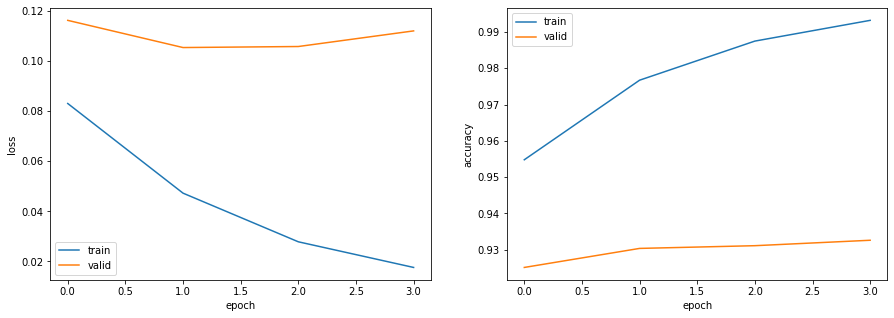

In [25]:
visualize_logs(log)

In [27]:
def calculate_accuracy(model, dataset, device):
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      outputs = model.forward(ids, mask, return_dict=False)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

print(f'accuracy (train)：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'accuracy (valid)：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'accuracy (test)：{calculate_accuracy(model, dataset_test, device):.3f}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2327: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


accuracy (train)：0.993
accuracy (valid)：0.933
accuracy (test)：0.939
